In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-analyst-job-roles-in-canada/Raw_Dataset.csv
/kaggle/input/data-analyst-job-roles-in-canada/Cleaned_Dataset.csv


In [17]:
# --- 0) Imports & Paths ---
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Kaggle input/working paths (change IN_PATH if running locally)
IN_PATH = "/kaggle/input/data-analyst-job-roles-in-canada/Cleaned_Dataset.csv"
OUT_DIR = "/kaggle/working"
os.makedirs(OUT_DIR, exist_ok=True)

# Wider table printing in the notebook
pd.set_option("display.max_columns", 120)


In [18]:
# --- 1) Load & Quick Scan ---
df = pd.read_csv(IN_PATH)

print("Shape:", df.shape)
display(df.head(3))                          # quick peek at first rows
display(df.isna().mean().sort_values(ascending=False).head(10))  # top missing columns


Shape: (1796, 13)


,Job Title,Job Info,Position,Employer,City,Province,Skill,Seniority,Work Type,Industry Type,Min_Salary,Max_Salary,Avg_Salary
0,Systems and Data Analysts,Binance Accelerator Program - Data Analyst (Risk),Risk Analyst,Binance,Remote,Undef,"Python, Sql",ANY,Remote,Others,76000.00,89440.0,82720.000
1,Business and Marketing Analysts,Business Analyst,Business Analyst,Canadian Nuclear Laboratories,Remote,Undef,"Power Bi, Power BI, Excel",ANY,Remote,Others,65000.00,87000.0,76000.000
2,Business and Technical Analysts,Geophysicist/Data Analyst,Data Analyst,Sander Geophysics Limited,Ottawa,ON,Undef,ANY,In-Person,Technology,64123.59,86600.0,75361.795


Job Title        0.0
Job Info         0.0
Position         0.0
Employer         0.0
City             0.0
Province         0.0
Skill            0.0
Seniority        0.0
Work Type        0.0
Industry Type    0.0
dtype: float64

In [19]:
# --- 2) Normalize Column Names (lower_snake_case) ---
def snake(s: str) -> str:
    return re.sub(r'[^a-z0-9]+', '_', s.strip().lower()).strip('_')

df.columns = [snake(c) for c in df.columns]
print("Columns:", list(df.columns))


Columns: ['job_title', 'job_info', 'position', 'employer', 'city', 'province', 'skill', 'seniority', 'work_type', 'industry_type', 'min_salary', 'max_salary', 'avg_salary']


In [20]:
# --- 3) Minimal Clean-up: Duplicates & Essential NAs ---
subset = [c for c in ['job_title','employer','city','province'] if c in df.columns]
if subset:
    before = len(df)
    df = df.drop_duplicates(subset=subset)
    print(f"Dedup by {subset}: {before} -> {len(df)}")

need = [c for c in ['city','province'] if c in df.columns]
if need:
    b = len(df)
    df = df.dropna(subset=need)
    print(f"Dropped NA in {need}: {b} -> {len(df)}")


Dedup by ['job_title', 'employer', 'city', 'province']: 1796 -> 1160
Dropped NA in ['city', 'province']: 1160 -> 1160


In [21]:
# --- 4) Salary: Describe & Basic Checks ---
num_cols = [c for c in ['min_salary','max_salary','avg_salary'] if c in df.columns]
if num_cols:
    display(df[num_cols].describe())
else:
    print("No numeric salary columns found; skip salary distribution.")


,min_salary,max_salary,avg_salary
count,1160.000000,1160.000000,1160.000000
mean,68857.893759,88591.702052,78724.797905
std,19357.573700,19988.201386,18226.233197
min,30240.560000,57200.000000,43720.280000
25%,60000.000000,80000.000000,70000.000000
50%,68000.000000,87000.000000,77750.000000
75%,80000.000000,93077.700000,88400.000000
max,137280.000000,180000.000000,158640.000000


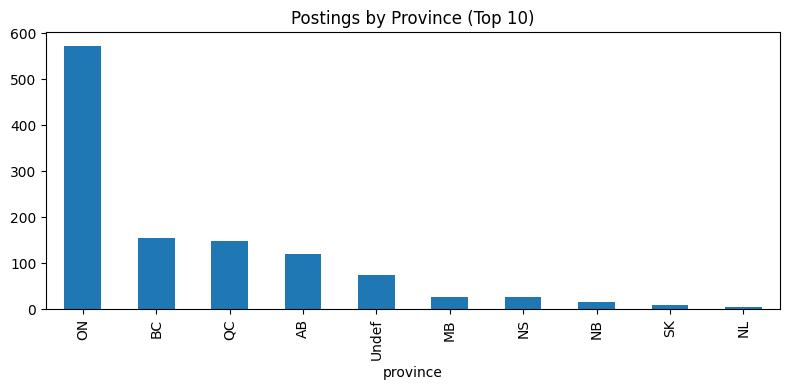

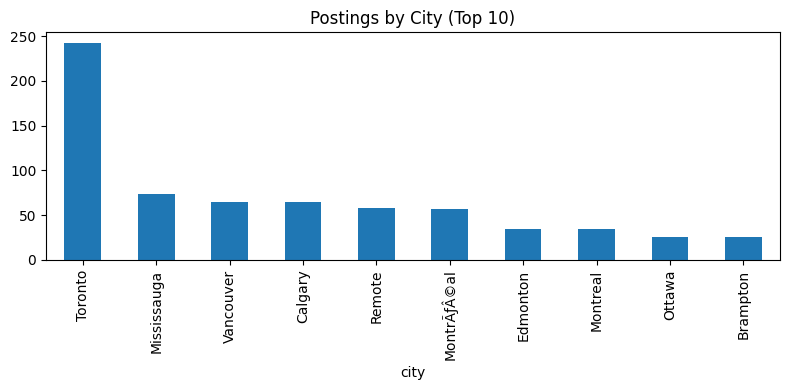

In [22]:
# --- 5) Regional Job Demand ---
if 'province' in df.columns:
    prov_counts = df['province'].value_counts().head(10)
    ax = prov_counts.plot(kind='bar', figsize=(8,4), title='Postings by Province (Top 10)')
    plt.tight_layout(); plt.savefig(f"{OUT_DIR}/postings_by_province.png"); plt.show()

if 'city' in df.columns:
    city_counts = df['city'].value_counts().head(10)
    ax = city_counts.plot(kind='bar', figsize=(8,4), title='Postings by City (Top 10)')
    plt.tight_layout(); plt.savefig(f"{OUT_DIR}/postings_by_city.png"); plt.show()


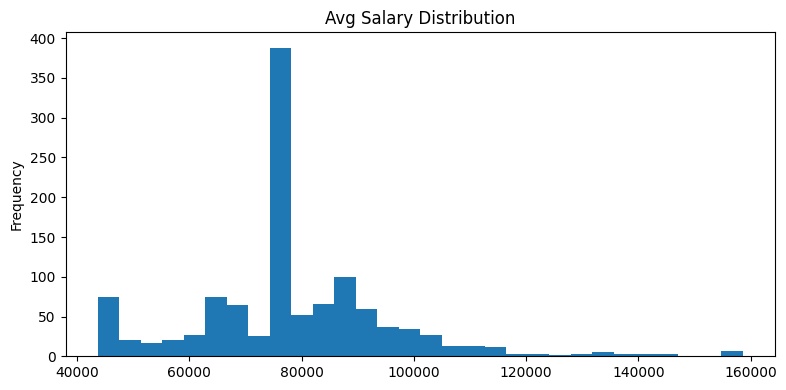

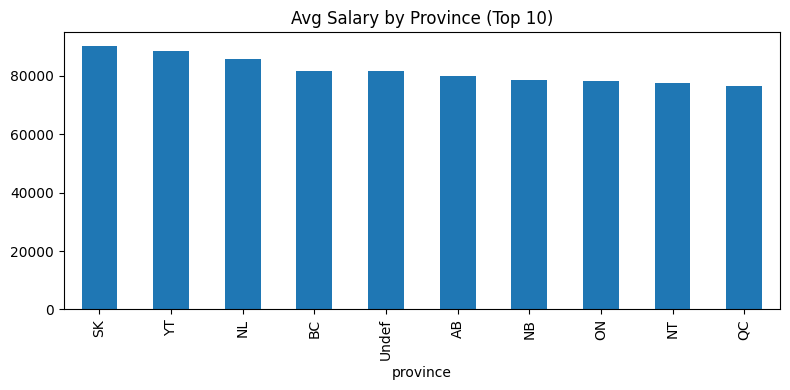

In [23]:
# --- 6) Salary Distribution & Province Averages ---
if 'avg_salary' in df.columns:
    df['avg_salary'].dropna().plot(kind='hist', bins=30, figsize=(8,4), title='Avg Salary Distribution')
    plt.tight_layout(); plt.savefig(f"{OUT_DIR}/avg_salary_distribution.png"); plt.show()

    if 'province' in df.columns:
        s = df.groupby('province')['avg_salary'].mean().sort_values(ascending=False).head(10).round(0)
        ax = s.plot(kind='bar', figsize=(8,4), title='Avg Salary by Province (Top 10)')
        plt.tight_layout(); plt.savefig(f"{OUT_DIR}/avg_salary_by_province.png"); plt.show()


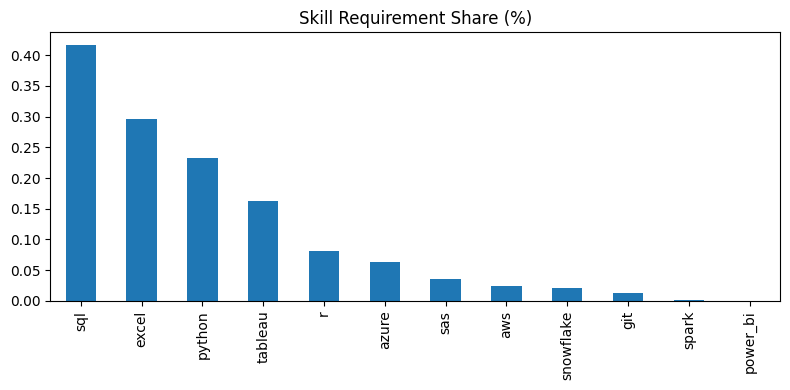

sql          41.6
excel        29.7
python       23.2
tableau      16.2
r             8.1
azure         6.3
sas           3.6
aws           2.4
snowflake     2.2
git           1.2
spark         0.2
power_bi      0.0
Name: requirement_%, dtype: float64

In [24]:
# --- 7) Skills One-Hot ---
core_skills = ['sql','python','excel','tableau','power_bi','r','sas','azure','aws','spark','snowflake','git']

def normalize_skill_text(s: str) -> str:
    if not isinstance(s, str): return ""
    t = s.lower()
    t = re.sub(r'\s+', ' ', t)
    t = t.replace('power-bi','power bi').replace('power  bi','power bi')
    t = t.replace('microsoft excel','excel').replace('ms excel','excel')
    return t

if 'skill' in df.columns:
    low = df['skill'].apply(normalize_skill_text)
    for k in core_skills:
        # \bword\b ensures we catch whole words, not substrings
        df[k] = low.str.contains(rf'\b{k}\b', regex=True).astype(int)

    # Skill requirement share
    present = [c for c in core_skills if c in df.columns]
    share = df[present].mean().sort_values(ascending=False)
    ax = share.plot(kind='bar', figsize=(8,4), title='Skill Requirement Share (%)')
    plt.tight_layout(); plt.savefig(f"{OUT_DIR}/skills_share.png"); plt.show()
    display((share*100).round(1).rename('requirement_%'))
else:
    print("No 'skill' column found; skipping one-hot.")


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,skill,avg_with,avg_without,delta
11,git,90037.0,78587.0,11450.0
8,aws,86910.0,78522.0,8388.0
7,azure,83327.0,78416.0,4911.0
1,python,82073.0,77714.0,4359.0
10,snowflake,82478.0,78642.0,3836.0
9,spark,79250.0,78724.0,526.0
5,r,78789.0,78719.0,70.0
6,sas,78264.0,78742.0,-478.0
3,tableau,77988.0,78867.0,-880.0
0,sql,78173.0,79119.0,-946.0


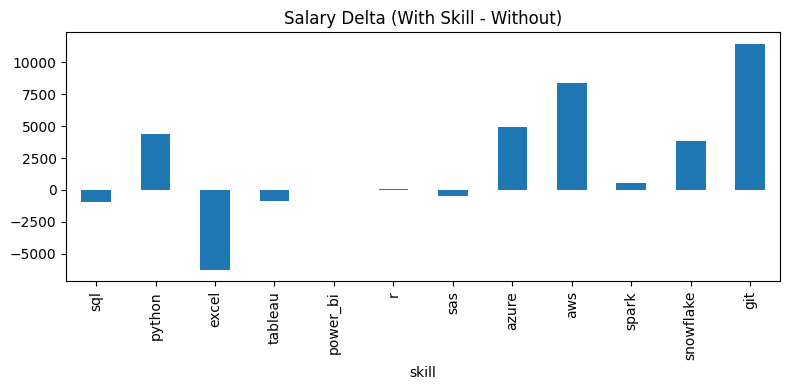

In [26]:
# --- 8) Skills vs Salary ---
if 'avg_salary' in df.columns:
    use = [c for c in core_skills if c in df.columns]
    rows = []
    for c in use:
        with_skill = df.loc[df[c]==1, 'avg_salary'].mean()
        without    = df.loc[df[c]==0, 'avg_salary'].mean()
        delta      = (with_skill - without) if pd.notna(with_skill) and pd.notna(without) else np.nan
        rows.append([c, round(with_skill or np.nan,0), round(without or np.nan,0), round(delta or np.nan,0)])

    comp = pd.DataFrame(rows, columns=['skill','avg_with','avg_without','delta'])
    display(comp.sort_values('delta', ascending=False))

    ax = comp.set_index('skill')['delta'].plot(kind='bar', figsize=(8,4), title='Salary Delta (With Skill - Without)')
    plt.tight_layout(); plt.savefig(f"{OUT_DIR}/skill_salary_delta.png"); plt.show()
else:
    print("No avg_salary column; skipping skill-salary comparison.")


In [27]:
# --- 9) Export BI-Ready CSV ---
keep = [c for c in ['job_title','employer','city','province','min_salary','max_salary','avg_salary',
                    'sql','python','excel','tableau','power_bi'] if c in df.columns]
bi = df[keep].copy()
bi_path = f"{OUT_DIR}/clean_for_bi.csv"
bi.to_csv(bi_path, index=False)
print("Saved BI-ready CSV:", bi_path)


Saved BI-ready CSV: /kaggle/working/clean_for_bi.csv


In [29]:
# --- Conclusion (short notes for reviewers) ---
summary = """
Key findings:
- Regional demand: Provinces with the most postings are shown in 'Postings by Province'.
- Pay: Average salaries cluster around ~70–90k, with higher medians in certain provinces.
- Skills: SQL and Python appear most frequently; BI tools (Tableau/Power BI) are also common.
- Skill vs Salary: Some skills show positive salary deltas; see 'Salary Delta' chart.

Next steps:
- Build an interactive dashboard (Power BI/Tableau) using 'clean_for_bi.csv'.
- Add filters for Province and Skills; show KPI cards (Avg Salary, # of Postings).
"""
print(summary)



Key findings:
- Regional demand: Provinces with the most postings are shown in 'Postings by Province'.
- Pay: Average salaries cluster around ~70–90k, with higher medians in certain provinces.
- Skills: SQL and Python appear most frequently; BI tools (Tableau/Power BI) are also common.
- Skill vs Salary: Some skills show positive salary deltas; see 'Salary Delta' chart.

Next steps:
- Build an interactive dashboard (Power BI/Tableau) using 'clean_for_bi.csv'.
- Add filters for Province and Skills; show KPI cards (Avg Salary, # of Postings).

